# Super-Resolution using Coordinate Nets

This is a quick experiment focused on upscaling images using neural nets. Please check out the accompanying [blog post](http://liviu.me/blog/super-resolution-using-coordinates-networks) for a high-level view of the idea.

In [1]:
# There are several libraries to install
#!pip3 install tensorflow numpy matplotlib scikit-image

%matplotlib inline

import itertools

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, transform

from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

## Load image

The code expects a local image filepath through the `image_path` variable below.

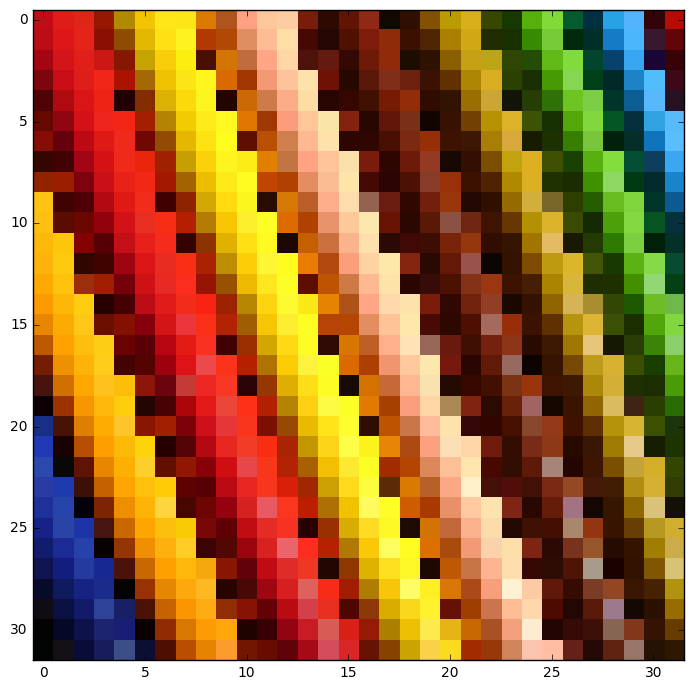

In [2]:
"""User Parameters"""
# The train image will be scaled to a square of dimensions `train_size x train_size`
train_size = 32
# When generating the image, the network will generate for an image of
# size `test_size x test_size`
test_size = 2048
# Path to load the image you want upscaled
image_path = '../img/colors.jpg'

if not image_path:
    print('Please specify an image for training the network')
else:
    image = transform.resize(io.imread(image_path), (train_size, train_size))
    # Just a quick line to get rid of the alpha channel if it exists
    # (e.g. for transparent png files)
    image = image if len(image.shape) < 3 or image.shape[2] == 3 else image[:,:,:3]
    io.imshow(image)

## Model

For simplicity, the model below is an MLP created with TF.

### Input

The input is just a matrix of floats of shape `(None, 2)`:
- 2 refers to the 2 `x`, `y` coordinates
- and `None` is just a placeholder that allows for training multiple coordinates at one time for speed (i.e. using batches of unknown size)

In [3]:
X = tf.placeholder('float32', (None, 2)) 

## Architecture

An MLP with several fully connected layers. The architecture was inspired from [here](https://cs.stanford.edu/people/karpathy/convnetjs/demo/image_regression.html).

In [4]:
def model(X, w):
    h1 = tf.nn.tanh(tf.matmul(X, w['h1']))
    h2 = tf.nn.tanh(tf.matmul(h1, w['h2']))
    h3 = tf.nn.tanh(tf.matmul(h2, w['h3']))
    h4 = tf.nn.tanh(tf.matmul(h3, w['h4']))
    h5 = tf.nn.tanh(tf.matmul(h4, w['h4']))
    h6 = tf.nn.tanh(tf.matmul(h5, w['h4']))
    h7 = tf.nn.tanh(tf.matmul(h6, w['h4']))
    h8 = tf.nn.tanh(tf.matmul(h7, w['h4']))    
    return tf.nn.sigmoid(tf.matmul(h8, w['out']))

In [5]:
def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

# (None, None) refers to (batch_size, n_colors)
Y = tf.placeholder("float32", (None, None))

w = {
  'h1': init_weights([2, 20]),
  'h2': init_weights([20, 20]),
  'h3': init_weights([20, 20]),
  'h4': init_weights([20, 20]),
  'h5': init_weights([20, 20]),
  'h6': init_weights([20, 20]),
  'h7': init_weights([20, 20]),
  'h8': init_weights([20, 20]),
  'out': init_weights([20, 3]),
}

out = model(X, w)

## Training

The model is trained to minimise MSE (common loss for regression problems) and uses Adam as an optimiser (any other optimiser will likely also work).

In [6]:
cost = tf.reduce_mean(tf.squared_difference(out, Y))
train_op = tf.train.AdamOptimizer().minimize(cost)

In [7]:
# Feel free to adjust the number of epochs to your liking.
n_epochs = 5e+4

# Create function to generate a coordinate matrix (i.e. matrix of normalised coordinates)
# Pardon my lambda 
generate_coord = lambda size: (
    np.array(list(itertools.product(np.linspace(0,1,size),np.linspace(0,1,size)))).reshape(size ** 2, 2))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training data
    x = generate_coord(train_size)
    # Labels
    reshaped_image = np.array(image.reshape(train_size ** 2, -1))
    
    for epoch in range(int(n_epochs + 1)):
        _, c = sess.run([train_op, cost], feed_dict={X: x, Y: reshaped_image})
        
        # Print progress
        if epoch % (n_epochs/10) == 0:
            print('{:0.0%} \t Loss: {}'.format(epoch/n_epochs, c).expandtabs(7))
    
    # Generate
    new_image = sess.run(out, feed_dict={X: generate_coord(test_size)})

0%      Loss: 0.13449391722679138
10%     Loss: 0.013441384769976139
20%     Loss: 0.011676935479044914
30%     Loss: 0.008169658482074738
40%     Loss: 0.007350752595812082
50%     Loss: 0.006482691969722509
60%     Loss: 0.007961291819810867
70%     Loss: 0.006531702820211649
80%     Loss: 0.005579670425504446
90%     Loss: 0.005484508350491524
100%    Loss: 0.00547614274546504


## Evaluation

aka plotting the generated image and carefully considering whether it meets the desired standards or there's a need for readjusting either the hyperparameters or the expectations.

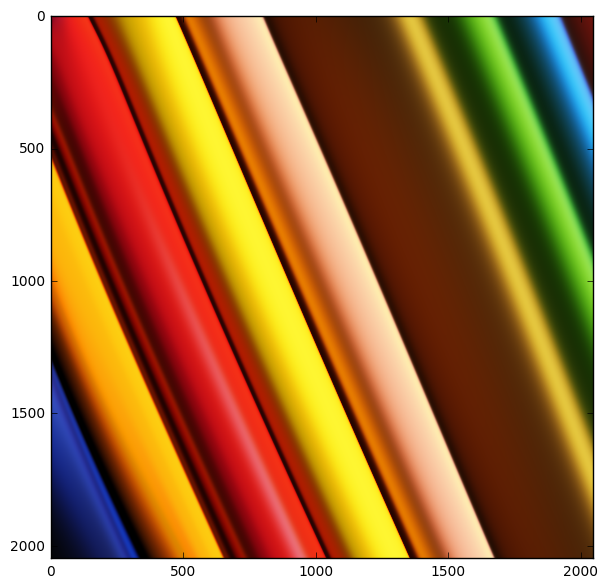

In [8]:
plt.imshow(new_image.reshape(test_size, test_size, -1))